In [2]:
import torch
from tqdm import tqdm
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [3]:
train = torchvision.datasets.MNIST(
    root="./",
    train=True,
    download=True,
    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
]),
)

train_loader = DataLoader(train, batch_size=64, 
                          shuffle=True)

torch.Size([1, 28, 28])


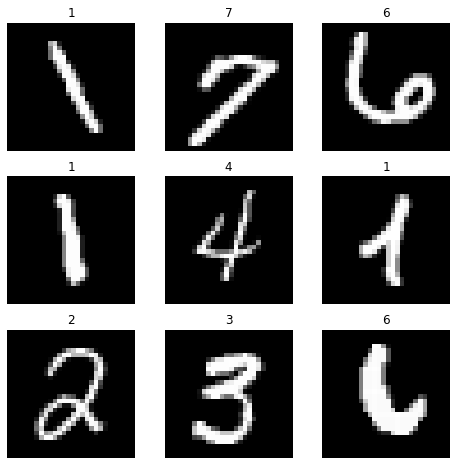

In [4]:
print(train[0][0].shape)
figure = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
class Generator(nn.Module):
    
    def __init__(self, input_shape):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.generator(x).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return self.discriminator(x)

In [7]:
def label_real(size):
    data = torch.ones(size, 1)
    return data

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data

def get_noise(batch_size, size):
    return torch.randn(batch_size, size)

def save_generator_image(image, path):
    save_image(image, path)

In [8]:
def train_discriminator(model, optimizer, criterion, 
                        data_real, data_fake):
    batch_size = data_fake.size(0)
    real_labels = label_real(batch_size)
    fake_labels = label_fake(batch_size)
    
    optimizer.zero_grad()
    
    output_real = model(data_real)
    loss_real = criterion(output_real, real_labels)
    
    output_fake = model(data_fake)
    loss_fake = criterion(output_fake, fake_labels)
    
    loss_real.backward()
    loss_fake.backward()
    
    optimizer.step()
    
    return loss_real + loss_fake

In [9]:
def train_generator(model, discriminator, optimizer, criterion, 
                        data_fake):
    batch_size = data_real.size(0)
    real_labels = label_real(batch_size)
    
    optimizer.zero_grad()
    
    output = discriminator(data_fake)
    loss = criterion(output, real_labels)
    
    loss.backward()
    
    optimizer.step()
    
    return loss

In [ ]:
gen = Generator(128)
dis = Discriminator(784)
criterion = nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters())
dis_opt = torch.optim.Adam(dis.parameters())

batch_size = 64
n_epochs = 40
k = 1
noise = get_noise(batch_size, 128)
gen_losses = []
dis_losses = []
images = []

for epoch in range(n_epochs):
    gen_loss = 0
    dis_loss = 0
    total = int(len(train)/train_loader.batch_size)
    for i, data in tqdm(enumerate(train_loader), total=total):
        image, _ = data
        
        for step in range(k):
            data_fake = gen(get_noise(len(image), 128)).detach()
            data_real = image
            dis_loss += train_discriminator(dis, dis_opt, criterion, 
                                            data_real, data_fake)
            
        data_fake = gen(get_noise(len(image), 128))
        # train the generator network
        gen_loss += train_generator(gen, dis, gen_opt, 
                                    criterion, data_fake)
        
    # create the final fake image for the epoch
    generated_img = gen(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./outputs/gen_img{epoch}.png")
#     images.append(generated_img)
    epoch_loss_g = gen_loss / i # total generator loss for the epoch
    epoch_loss_d = dis_loss / i # total discriminator loss for the epoch
    gen_losses.append(epoch_loss_g)
    dis_losses.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {40}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    del generated_img

938it [01:21, 11.56it/s]                         
  0%|          | 2/937 [00:00<01:33, 10.04it/s]

Epoch 0 of 40
Generator loss: 13.99250793, Discriminator loss: 0.00682970


938it [01:24, 11.14it/s]                         
  0%|          | 2/937 [00:00<01:24, 11.07it/s]

Epoch 1 of 40
Generator loss: 14.79564190, Discriminator loss: 0.00000073


938it [01:22, 11.33it/s]                         
  0%|          | 2/937 [00:00<01:26, 10.75it/s]

Epoch 2 of 40
Generator loss: 15.30580330, Discriminator loss: 0.00000045


938it [01:22, 11.34it/s]                         
  0%|          | 1/937 [00:00<01:44,  8.98it/s]

Epoch 3 of 40
Generator loss: 15.88470745, Discriminator loss: 0.00000027


938it [01:29, 10.51it/s]                         
  0%|          | 1/937 [00:00<01:46,  8.79it/s]

Epoch 4 of 40
Generator loss: 16.46187401, Discriminator loss: 0.00000015


938it [01:38,  9.52it/s]                         
  0%|          | 1/937 [00:00<02:09,  7.22it/s]

Epoch 5 of 40
Generator loss: 17.04143333, Discriminator loss: 0.00000009


938it [01:46,  8.81it/s]                         
  0%|          | 1/937 [00:00<01:47,  8.72it/s]

Epoch 6 of 40
Generator loss: 17.62129784, Discriminator loss: 0.00000005


938it [02:31,  6.21it/s]                         
  0%|          | 1/937 [00:00<02:29,  6.25it/s]

Epoch 7 of 40
Generator loss: 18.21729088, Discriminator loss: 0.00000003


938it [02:48,  5.57it/s]                         
  0%|          | 1/937 [00:00<01:58,  7.90it/s]

Epoch 8 of 40
Generator loss: 18.79138947, Discriminator loss: 0.00000001


938it [03:23,  4.61it/s]                         
  0%|          | 1/937 [00:00<02:58,  5.23it/s]

Epoch 9 of 40
Generator loss: 19.35354042, Discriminator loss: 0.00000001


 71%|███████   | 661/937 [09:26<4:08:06, 53.94s/it]

In [13]:
import numpy as np
import imageio
to_pil_image = torchvision.transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('./outputs/generator_images.gif', imgs)